In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Finding the roots of a Legendre polynomial with respect to the index ##

In class we looked at the problem of finding the potential, $\Phi$, in a conical hole drilled into a grounded conductor.  We solved this problem using separation of variables in spherical coordinates, so our solution looked liked power laws in $r$ times [Legendre functions](https://en.wikipedia.org/wiki/Legendre_function).  Our hole was azimuthally symmetric, so we didn't have any $\varphi$ dependence and we didn't need the "associated" Legendre functions.

In order for $\Phi$ to vanish at the conducting surface, $\theta=\beta$, we needed to find the index $\nu$ such that $P_\nu(\cos\beta)=0$.  How does one go about this problem?

### Exploration ###

Let's just have a look at the Legendre functions before we start trying to solve our boundary condition.  For this purpose we'll cheat and use SciPy's built in Legendre routines.  There are two.  One evaluates the polynomials, the other uses the fact that $P_\nu$ can be written as a [hypergeometric function](https://en.m.wikipedia.org/wiki/Hypergeometric_function)
$$
  P_\nu(x) = {}_2F_1\left(-\nu,\nu+1;1;\xi\equiv \frac{1-x}{2}\right)
$$
so we can use this in any special function library that has a routine for ${}_2F_1$, e.g. SciPy.

In [2]:
# SciPy has the Legendre polynomials built in and does the Legendre
# functions through it's hypergeometric routine
from scipy.special import eval_legendre as legendre_function

Text(0, 0.5, '$P_\\nu(x)$')

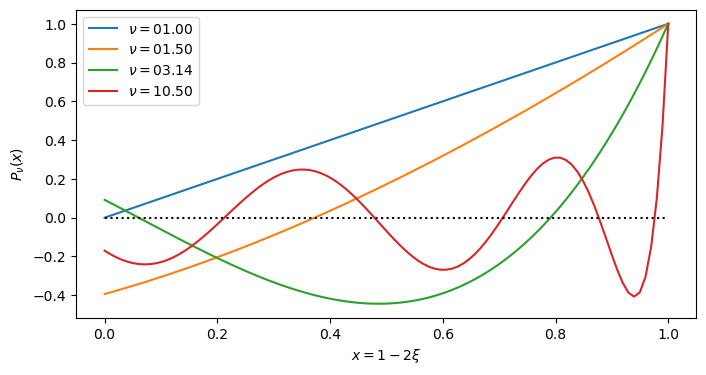

In [3]:
# Let's just plot a few, to see how they look:
fig,ax = plt.subplots(1,1,figsize=(8,4))
#
xx = np.linspace(0.0,1.0,100)
for nu in [1.0,1.5,np.pi,10.5]:
    ax.plot(xx,legendre_function(nu,xx),label=r'$\nu='+"{:05.2f}$".format(nu))
ax.plot(xx,np.zeros_like(xx),'k:')
ax.legend()
ax.set_xlabel(r'$x=1-2\xi$')
ax.set_ylabel(r'$P_\nu(x)$')

### Power series ###

Ok, but what if we want to code this up ourselves?  For the whole interval $x\in [-1,1]$, given the Legendre DE we would have proceeded to solve it using the Frobenius method with $P_\nu(x)=\sum_n a_n x^n$ (i.e. expanding around $x=0$).  Focusing on the solution regular at $x=1$ we have:
$$
  \frac{a_{n+2}}{a_n} = -\frac{\left[\nu+n+1\right]\left(\nu-n\right)}{(n+1)(n+2)}
$$
so we need to provide two "initial conditions".  For integer $\nu$ this is pretty easy.  Remember the polynomials are either even or odd so either $a_0=0$ or $a_1=0$ and the non-zero one can be fixed by requiring $P_n(1)=1$.  The requirement that one of $a_0$ or $a_1$ be zero follows from requiring the series to terminate as usual (the other one terminates when $n=\nu$).  We can derive the $P_n(x)$ from the above recurrence relation or we can use [Gramm-Schmidt orthogonalization](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) (a.k.a. [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition)) starting from the monomial basis $\{1,x,x^2,x^3,\cdots\}$ with the natural dot product on $x\in [-1,1]$.

When $\nu$ is not an integer, i.e. Legendre functions rather than polynomials, the function is neither even nor odd.  We have a few ways to proceed.  From the general theory of 2nd order ODEs with singular points we can map this to the hypergeometric equation, hence we already have the hypergeometric series (above) and hence the solution ...  What about evolving our DE from $x=1$?  We know $P_\nu(1)=1$ from the "conventional normalization".  Let's consider $P'_\nu(1)$.  For integer $\nu$:
$$
  P'_0(1)=0 \quad , \quad
  P'_1(1)=1 \quad , \quad
  P'_2(1)=3 \quad , \quad
  P'_3(1)=6 \quad , \quad
  P'_4(1)=10
$$
or $P'_n(1)=n(n+1)/2$.  The natural (and correct) choice for $P'_\nu(1)$ is therefore $\nu(\nu+1)/2$ when $\nu$ is a real number.  Given $P_\nu(1)$ and $P'_\nu(1)$ we can evolve $P(x)$ numerically.

Finally, and probably the "right" way, we can still use Frobenius.  But we shouldn't really be using Frobenius around $x=0$ for this problem.  The best way, taken in Jackson's book, is to rewrite the equation as a power series in $\xi=(1-x)/2$.  Then using Frobenius about $\xi=0$ (i.e. $x=1$) you find $P_\nu(\xi)=\sum_n c_n \xi^n$ with $c_{n+1/c_n}=[n(n+1)-\nu(\nu+1)]/(n+1)^2$.  This directly gives you the expansion in the hypergeometric function show above (almost all of the special functions can be mapped to hypergeometric functions).

So we have two obvious approaches at this point.  One is to use a "standard" ODE solve to evolve $P_\nu$ from $x=1$.  The other is to use the power series.  We would probably do something clever to evaluate the resulting power series.  It's not that easy to do clever things in Python, but NumPy has a polynomial class which is pretty efficient which we can "hack" to do power series.  It's actually a little easier to do the power series in $\xi=(1/2)(1-x)$, i.e. the way the hypergeometric function does it:

In [4]:
def frobenius_series(nu,nmax=10):
    """Returns a polynomial object containing the power
    series up to order nmax in xi=(1/2)(1-x)."""
    #
    ans  = np.zeros(nmax,dtype='float')
    ans[0]=1.0
    an,bn,cn,nf = -nu,nu+1,1.0,1.0
    for n in range(1,nmax):
        ans[n] = an/cn*bn/nf
        an *= (n-nu)
        bn *= (nu+1+n)
        cn *= n+1
        nf *= n+1
    Pnu = np.poly1d(ans[::-1])
    return(Pnu)
print(frobenius_series(3.0,7))
print(frobenius_series(1.5,7))

     3      2
-20 x + 30 x - 12 x + 1
        6          5          4          3         2
0.1002 x + 0.1375 x + 0.2115 x + 0.4102 x + 1.641 x - 3.75 x + 1


Looking at the power series for "typical" values of $\nu$, the terms increase until $n\sim\nu$ then start to decrease.  Let's take a look:

Text(0, 0.5, 'Ratio')

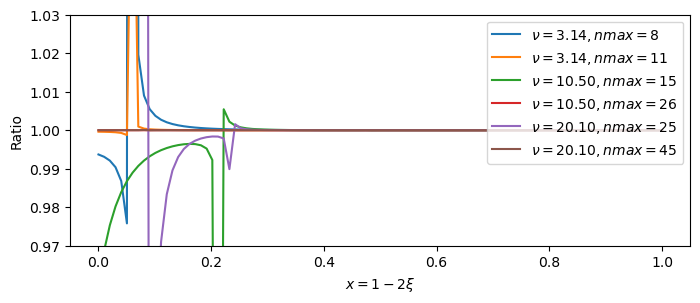

In [5]:
# Let's compare our power series to "truth" for various
# values of nmax and x.
fig,ax = plt.subplots(1,1,figsize=(8,3))
#
xx = np.linspace(0,1.0,100)
xi = 0.5*(1-xx)
for nu in [np.pi,10.5,20.1]:
    ex = legendre_function(nu,xx)
    for nmax in [int(nu+5),int(2*nu+5)]:
        ap = frobenius_series(nu,nmax)(xi)
        ax.plot(xx,ap/ex,label=r'$\nu='+"{:4.2f}, nmax={:d}$".format(nu,nmax))
ax.legend(loc=1)
ax.set_ylim(0.97,1.03)
ax.set_xlabel(r'$x=1-2\xi$')
ax.set_ylabel(r'Ratio')

Clearly keeping a few terms is more than enough for small values of $\nu$.  However as we go to higher and higher values of $\nu$ we need to keep (many) more terms.  It looks like keeping $n_{\rm max}>\nu$ is good enough for $\xi>1/3$ or so.  Let's choose $n_{\rm max}\approx 2\nu$ to be safe.

To be definite, let's decide that $\cos\beta=1/2$ or $\xi=1/4$.
Just to orient ourselves, let's plot $P_\nu(\cos\beta)$ as a function of $\nu$ ...

Text(0, 0.5, '$P_\\nu(\\cos\\beta)$')

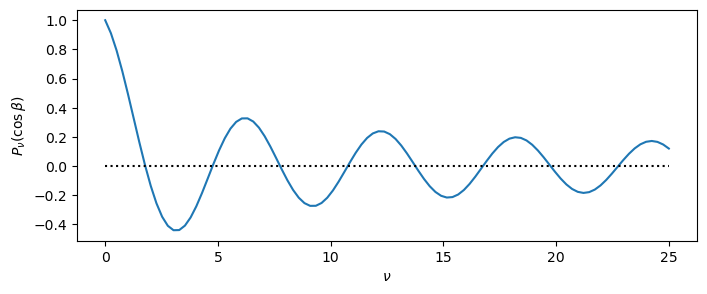

In [6]:
# Plot P_nu(\cos\beta) as a function of nu
# Use \cos\beta=1/2
cosb = 0.5
xi   = 0.5*(1-cosb)
nu   = np.linspace(0,25,100)
Pnu  = np.array([frobenius_series(nn,nmax=int(2*nn+5))(xi) for nn in nu])
#
fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(nu,Pnu)
ax.plot(nu,np.zeros_like(nu),'k:')
ax.set_xlabel(r'$\nu$')
ax.set_ylabel(r'$P_\nu(\cos\beta)$')

Just looking at this plot we see the roots are separated by $\Delta\nu>1$, so that could inform our root finding strategy.  We will need to first get close to, or bracket, a root and then refine it.  Let's start with the dumbest methods ... so the code is not super slow we'll use the inbuilt routines for $P_\nu(x)$, which call other languages under-the-hood: 

In [7]:
def bisection(nu0,nu1,f0,f1,eps=5e-4):
    """Solves P_nu(cosb)=0 using bisection."""
    if f0*f1>=0:
        raise RuntimeError("Root not bracketed!")
    while np.abs(nu1-nu0)>eps:
        nu2= 0.5*(nu0+nu1)
        f2 = legendre_function(nu2,cosb)
        if f2*f0<0:
            nu0,nu1,f0,f1 = nu0,nu2,f0,f2
        else:
            nu0,nu1,f0,f1 = nu2,nu1,f2,f1
    nu2 = 0.5*(nu0+nu1)
    return(nu2)

In [8]:
# Walk up in nu, looking for roots.
nu0,nu1 = 0.0,1.0
f0,f1   = legendre_function(nu0,cosb),legendre_function(nu1,cosb)
for n in range(1,5):
    while f0*f1>0:
        nu1 += 1.0
        f1   = legendre_function(nu1,cosb)
    print("Root {:d} bracketed by {:.2f}<nu<{:.2f}".format(n,nu0,nu1))
    root = bisection(nu0,nu1,f0,f1)
    froot= legendre_function(root,cosb)
    print("Root {:d} at nu={:.4f} (P={:e})".format(n,root,froot))
    #
    nu0   = nu1+1.0
    nu1   = nu0+1.0
    f0,f1 = legendre_function(nu0,cosb),legendre_function(nu1,cosb)

Root 1 bracketed by 0.00<nu<2.00
Root 1 at nu=1.7771 (P=1.118248e-04)
Root 2 bracketed by 3.00<nu<5.00
Root 2 at nu=4.7629 (P=6.258903e-05)
Root 3 bracketed by 6.00<nu<8.00
Root 3 at nu=7.7581 (P=6.316475e-05)
Root 4 bracketed by 9.00<nu<11.00
Root 4 at nu=10.7561 (P=4.195521e-06)


Ok, so this is certainly serviceable and if we only had to do this a few times it would be pretty quick to code and we'd have our answer and be able to get on with our lives.

What if we actually needed to do this a whole bunch for different values of $\beta$ or needed to do this as part of some control system or something?

We could improve our root finder.  Using [false-position](https://en.wikipedia.org/wiki/Regula_falsi) or [Ridder](https://en.wikipedia.org/wiki/Ridders%27_method) would be a quick change.

We could also do a "fake" higher order method by computing $P_\nu(\cos\beta)$ for some values of $\nu$ in our interval then fitting a spline to $\nu(P)$ and asking for the value at $P=0$.  This has a fixed "cost", in terms of the number of function evaluations, but we don't have much control over the accuracy.  And obviously it depends upon having a good guess for the interval early on:

In [9]:
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
#
def spline_method(nu0,nu1,f0,f1,Npnt=5):
    """Uses a spline to solve for the root."""
    nus    = np.linspace(nu0,nu1,Npnt,endpoint=True)
    Ps     = np.zeros_like(nus)
    Ps[ 0] = f0
    Ps[-1] = f1
    for n in range(1,Npnt):
        Ps[n] = legendre_function(nus[n],cosb)
    if f1>f0:
        root = Spline(Ps,nus)(0.0)
    else:
        root = Spline(Ps[::-1],nus[::-1])(0.0)
    return(root)

In [10]:
# Walk up in nu, looking for roots.
nu0,nu1 = 0.0,1.0
f0,f1   = legendre_function(nu0,cosb),legendre_function(nu1,cosb)
for n in range(1,5):
    while f0*f1>0:
        nu1 += 1.0
        f1   = legendre_function(nu1,cosb)
    print("Root {:d} bracketed by {:.2f}<nu<{:.2f}".format(n,nu0,nu1))
    #
    root = spline_method(nu0,nu1,f0,f1)
    froot= legendre_function(root,cosb)
    print("Root {:d} at nu={:.4f} (P={:e})".format(n,root,froot))
    #
    nu0   = nu1+1.0
    nu1   = nu0+1.0
    f0,f1 = legendre_function(nu0,cosb),legendre_function(nu1,cosb)

Root 1 bracketed by 0.00<nu<2.00
Root 1 at nu=1.7809 (P=-2.122616e-03)
Root 2 bracketed by 3.00<nu<5.00
Root 2 at nu=4.9059 (P=5.505098e-02)
Root 3 bracketed by 6.00<nu<8.00
Root 3 at nu=8.1334 (P=-1.116827e-01)
Root 4 bracketed by 9.00<nu<11.00
Root 4 at nu=11.3887 (P=1.529170e-01)


Note this method isn't incredibly accurate, and in fact it missed the root near 10.7.  We'd need to use more spline points to get something "reasonable".

### Better root finding ###

Perhaps the best way would be try to use Newton-Raphson, which makes use of the derivative information as well.  Recall [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) tells us to find the solution of $f(x)=0$ by iterating $x\to x-f/f'$ starting from a point "near" the root.  When it works, it converges quadratically.

How would we compute $dP_\nu/d\nu$?  It's kind of clear how to do $dP_\nu/dx$, but less obvious how to do a derivative with respect to the order.  We could try to brute force it through using the known coefficients of the power series (which depend on $\nu$), but that's painful.  Let's think about another way, which (conveniently!) introduces another representation of the Legendre functions ...

### Integral representation ###

Like most special functions, the Legendre polynomials have "integral represenations".  (For the integer arguments you can derive these from the generating function ($1/\sqrt{1+t^2-2xt}$ in our case) and contour integration, for other arguments you have to analytically continue).
There are versions where one does an integratral over $t\in[0,1]$ or $t\in[0,\infty)$ or where one integrates over the argument of a trigonometric or hyperbolic function.  Let's use the one in G&R(8.714):
$$
  P_\nu(\cos\theta) = \frac{\sqrt{2}}{\pi}\int_0^\theta dt\  \frac{\cos(\nu+1/2)t}{\sqrt{\cos t-\cos\theta}} 
$$
which is known as the "Mehler-Dirichlet" formula.
Note this tells us
$$
  \frac{dP_\nu}{d\nu} = -\frac{\sqrt{2}}{\pi}\int_0^\theta dt\  \frac{t\ \sin(\nu+1/2)t}{\sqrt{\cos t-\cos\theta}} 
$$

We want a relatively efficient way of doing the integrals, which is hard in pure Python so we'll need to call some library ... in our case SciPy.

In [11]:
# Compare P_nu(cosb) computed from our integral representation to
# the "true" value computed from the hypergeometric function.
nu   = 2.5
beta = np.pi/3.0
cosb = np.cos(beta)
ex   = legendre_function(nu,cosb)
print("nu={:f}, beta={:f}, cos(beta)={:f}, Pnu={:f}".format(nu,beta,cosb,ex))
#
from scipy.integrate import quad
#
func = lambda tt: np.cos((nu+0.5)*tt)/np.sqrt(np.cos(tt)-cosb)
ap   = np.sqrt(2.0)/np.pi*quad(func,0,beta)[0]
print("Integral is {:f}".format(ap))

nu=2.500000, beta=1.047198, cos(beta)=0.500000, Pnu=-0.339198
Integral is -0.339198


Now we can use Newton's method starting from a guess for the root.

In [12]:
def newton(nu,eps=1e-5):
    """Use Newton's method to find the root of Pnu(cosb).  When it works
    it will return nu for which Pnu~O(eps^2)"""
    func = lambda tt: tt*np.sin((nu+0.5)*tt)/np.sqrt(np.cos(tt)-cosb)
    fnu  = 1.0 # A random non-zero value.
    nstep = 0
    while np.abs(fnu)>eps:
        fnu  = legendre_function(nu,cosb)
        dfnu = -np.sqrt(2.0)/np.pi*quad(func,0,beta)[0]
        nu   = nu - fnu/dfnu
        nstep+= 1
    return( (nu,nstep) )

In [13]:
# Walk up in nu, looking for roots.
nu,nlist = 1.0,[]
for n in range(1,8):
    root,nstep = newton(nu)
    froot= legendre_function(root,cosb)
    print("Root {:d} near nu={:6.2f} is {:10.4f} (P={:e}, {:d} iterations)".\
          format(n,nu,root,froot,nstep))
    nlist.append(root)
    #
    nu = root+2.0

Root 1 near nu=  1.00 is     1.7773 (P=1.240057e-15, 3 iterations)
Root 2 near nu=  3.78 is     4.7628 (P=4.972886e-16, 5 iterations)
Root 3 near nu=  6.76 is     7.7583 (P=1.144817e-16, 5 iterations)
Root 4 near nu=  9.76 is    10.7561 (P=1.293667e-15, 5 iterations)
Root 5 near nu= 12.76 is    13.7548 (P=6.838796e-12, 4 iterations)
Root 6 near nu= 15.75 is    16.7540 (P=-9.765872e-12, 4 iterations)
Root 7 near nu= 18.75 is    19.7534 (P=-3.477164e-15, 5 iterations)


So this is very efficient, we're taking only a few steps in the Newton iteration to get to our root, and we're finding it with high accuracy.

Let's take a look at the functions we produced.

Text(0, 0.5, '$P_{\\nu}(x)$')

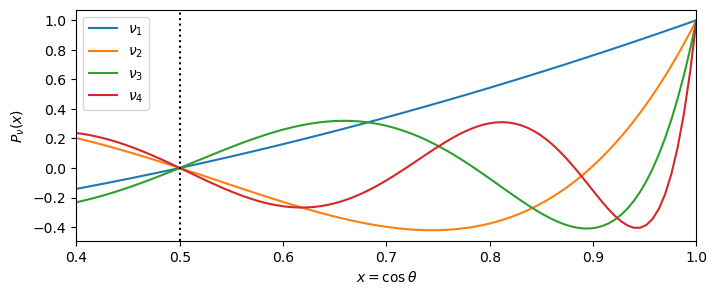

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8,3))
#
icol= 0
xx  = np.linspace(cosb-0.1,1.0,100)
for i,nu in enumerate(nlist[:4]):
    col = 'C' + str(i%10)
    fnu  = legendre_function(nu,xx)
    ax.plot(xx,fnu,'-',color=col,label=r'$\nu_'+str(i+1)+r'$')
ax.axvline(cosb,ls=':',color='k') # Mark where we want our zeros.
ax.legend()
ax.set_xlim(cosb-0.1,1.0)
ax.set_xlabel(r'$x=\cos\theta$')
ax.set_ylabel(r'$P_{\nu}(x)$')

But we have to be careful here ... starting from a place not too near the root can give you the wrong root, or you can get stuck.  Look at the following choices, which don't seem to crazy to begin with:

In [15]:
# Walk up in nu, looking for roots.
nu = 0.0
for n in range(1,5):
    root,nstep = newton(nu)
    froot= legendre_function(root,cosb)
    print("Root {:d} near nu={:.2f} is {:f} (P={:e}, {:d} iterations)".\
          format(n,nu,root,froot,nstep))
    #
    nu = root+1.0

Root 1 near nu=0.00 is 4.762779 (P=-1.181060e-15, 12 iterations)
Root 2 near nu=5.76 is 4.762779 (P=-8.661586e-12, 5 iterations)
Root 3 near nu=5.76 is 4.762779 (P=-8.661524e-12, 5 iterations)
Root 4 near nu=5.76 is 4.762779 (P=-8.661524e-12, 5 iterations)


/tmp/ipykernel_248/1857101308.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  dfnu = -np.sqrt(2.0)/np.pi*quad(func,0,beta)[0]


If we wanted to be careful about this, and it wasn't easy to just plot the results or watch the code while it ran, then we would be better off with a root finder that guaranteed convergence.

Finally, I should say that there are other identities that could be used to derive $dP_\nu/d\nu$, e.g. starting from the defining ODE itself and differentating w.r.t. $\nu$.

## Small-angle relations ##

We also know that $P_\nu(\cos\theta)$ can be approximated by $J_0\left([2\nu+1]\sin\frac{\theta}{2}\right)$ for $\nu\gg 1$ and $\theta\ll 1$.
At first sight these sorts of relations appear mysterious, but remember $P_\nu$ and $J_0$ are both eigenfunctions of the Laplacian, just in different coordinate systems.  In this case the physical content of the relation is that near the north pole of a sphere ($\theta\ll 1$) the surface looks flat (so we can use polar coordinates).

Let's see how well this works ...

In [16]:
from scipy.special import jn as besselJ
#
for theta in np.logspace(-2.0,-0.25,10):
    outstr = "{:8.5f}".format(theta)
    for nu in [np.pi,10.5]:
        ex = legendre_function(nu,np.cos(theta))
        ap = besselJ(0,(2*nu+1)*np.sin(theta/2))
        outstr += " {:12.4e}/{:12.4e} ({:8.5f})".format(ex,ap,ap/ex)
    print(outstr)

 0.01000   9.9967e-01/  9.9967e-01 ( 0.99999)   9.9698e-01/  9.9698e-01 ( 0.99999)
 0.01565   9.9920e-01/  9.9919e-01 ( 0.99998)   9.9262e-01/  9.9261e-01 ( 0.99998)
 0.02448   9.9805e-01/  9.9801e-01 ( 0.99996)   9.8198e-01/  9.8195e-01 ( 0.99996)
 0.03831   9.9523e-01/  9.9514e-01 ( 0.99991)   9.5618e-01/  9.5609e-01 ( 0.99991)
 0.05995   9.8834e-01/  9.8812e-01 ( 0.99978)   8.9440e-01/  8.9424e-01 ( 0.99981)
 0.09380   9.7157e-01/  9.7106e-01 ( 0.99947)   7.5141e-01/  7.5119e-01 ( 0.99971)
 0.14678   9.3108e-01/  9.2996e-01 ( 0.99880)   4.4757e-01/  4.4791e-01 ( 1.00076)
 0.22967   8.3528e-01/  8.3332e-01 ( 0.99765)  -6.2125e-02/ -5.8699e-02 ( 0.94485)
 0.35938   6.2003e-01/  6.1920e-01 ( 0.99868)  -4.0410e-01/ -4.0075e-01 ( 0.99172)
 0.56234   1.9786e-01/  2.1183e-01 ( 1.07060)   2.0429e-01/  1.7846e-01 ( 0.87357)


So not a bad approximation, even for relatively modest $\nu$ and large $\theta$.

Since the zeros of $J_0$ have been well tabulated already, this method is the "convert the problem to one which has already been solved" method.  In general it's a great method if you're pressed for time and happen to know the solution ...